In [1]:
%matplotlib widget

In [2]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [3]:
from microscope_calibration.common.model import (
    Parameters4DSTEM, Model4DSTEM, Result4DSTEM, PixelYX, CoordXY, identity, rotate, scale, flip_y,
    DescanError
)
from microscope_calibration.util.stem_overfocus_sim import smiley, project

In [4]:
np.arctan2(8, 1)

np.float64(1.446441332248135)

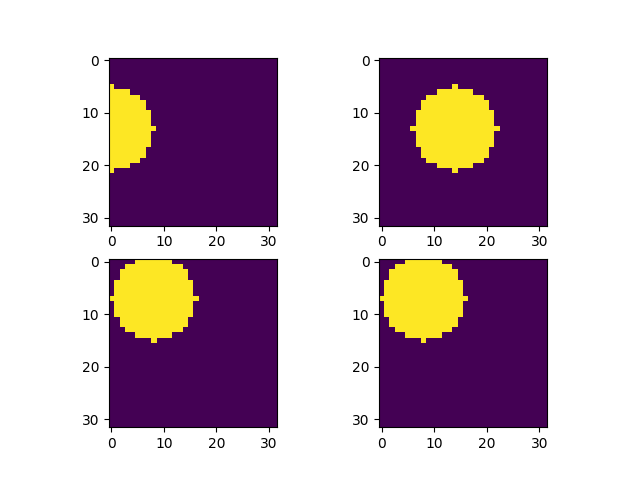

In [10]:
scan_pixel_pitch = 0.1
detector_pixel_pitch = 2 * scan_pixel_pitch
detector_pixel_pitch = 0.2
overfocus = 1.
camera_length = 1.
propagation_distance = overfocus + camera_length
obj_half_size = 16
angle = np.arctan2(obj_half_size*detector_pixel_pitch/2 + 0.00314157, propagation_distance)

params = Parameters4DSTEM(
    overfocus=overfocus,
    scan_pixel_pitch=scan_pixel_pitch,
    camera_length=camera_length,
    detector_pixel_pitch=detector_pixel_pitch,
    semiconv=angle,
    scan_center=PixelYX(x=obj_half_size, y=obj_half_size),
    scan_rotation=0.,
    flip_y=False,
    detector_center=PixelYX(x=obj_half_size, y=obj_half_size),
    descan_error=DescanError(
        offpxi=detector_pixel_pitch,
        offpyi=detector_pixel_pitch * 2,
        offsxi=-3 * detector_pixel_pitch/camera_length,
        offsyi=-5 * detector_pixel_pitch/camera_length,
        pxo_pxi=7 * detector_pixel_pitch/scan_pixel_pitch,
        pyo_pyi=11 * detector_pixel_pitch/scan_pixel_pitch,
        sxo_pxi=-13 * detector_pixel_pitch/scan_pixel_pitch/camera_length,
        syo_pyi=-17 * detector_pixel_pitch/scan_pixel_pitch/camera_length,
    )
)
#obj = smiley(obj_half_size * 2)
obj = np.ones((obj_half_size * 2, obj_half_size * 2))

ref = obj.copy()
ys, xs = np.ogrid[:obj.shape[0], :obj.shape[1]]
ys -= obj_half_size + 2 - 5
dist = np.sqrt(ys**2 + xs**2)

ref[dist > obj_half_size/2 + 0.00314157] = 0

ref2 = obj.copy()
ys, xs = np.ogrid[:obj.shape[0], :obj.shape[1]]
ys -= obj_half_size + 2 - 5 + 11 - 17
xs -= obj_half_size + 1 - 3 + 7 - 13
dist = np.sqrt(ys**2 + xs**2)

ref2[dist > obj_half_size/2 + 0.001] = 0

projected = project(
    image=obj,
    detector_shape=(32, 32),
    scan_shape=(32, 32),
    sim_params=params,
)

fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(ref)
axes[0, 1].imshow(projected[16, 16, :, :])

axes[1, 0].imshow(ref2)
axes[1, 1].imshow(projected[17, 17, :, :])

In [12]:
np.tan(np.pi/2)

np.float64(1.633123935319537e+16)

In [ ]:
p = OverfocusParams(
    overfocus=1,
    scan_pixel_size=1,
    camera_length=1,
    detector_pixel_size=1,
    cy=0,
    cx=0,
)
p	

In [ ]:
detector_px_to_specimen_px(
    y_px=1.,
    x_px=0.,
    fov_size_y=0,
    fov_size_x=0,
    transformation_matrix=np.array(((0., 1.), (1., 0.))),
    **p
)

In [ ]:
%autoreload
size = 32
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = smiley(size)
projected = project(
    image=obj,
    scan_shape=(size, size),
    detector_shape=(size, size),
    sim_params=params,
)

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(obj)
axes[1].imshow(projected[:, :, size//2, size//2])
axes[2].imshow(projected[:, :, size//2, size//2] - obj)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(obj)
axes[1].imshow(projected[size//2, size//2, :])
axes[2].imshow(projected[size//2, size//2, :] - obj)

In [ ]:
%autoreload
size = 32
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((size, size))
obj[size//2, size//2] = 1
sim = project(obj, scan_shape=(size, size), detector_shape=(size, size), sim_params=params)
assert sim[size//2, size//2, size//2, size//2] == 1

udf = OverfocusUDF(params)
ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

res = ctx.run_udf(dataset=ds, udf=udf, plots=True)

res['point']

In [ ]:
fig, axes = plt.subplots()
axes.imshow(sim[size//2, size//2])

In [ ]:
fig, axes = plt.subplots()
axes.imshow(sim[:, :, size//2 + 1, size//2 + 1])

In [ ]:
def get_translation_matrix(params: OverfocusParams, nav_shape):
    a = []
    b = []

    for det_y in (-10, 10):
        for det_x in (-10, 10):
            spec_y, spec_x = detector_px_to_specimen_px(
                y_px=float(det_y),
                x_px=float(det_x),
                fov_size_y=float(nav_shape[0]),
                fov_size_x=float(nav_shape[1]),
                transformation_matrix=get_transformation_matrix(params),
                cy=params['cy'],
                cx=params['cx'],
                detector_pixel_size=float(params['detector_pixel_size']),
                scan_pixel_size=float(params['scan_pixel_size']),
                camera_length=float(params['camera_length']),
                overfocus=float(params['overfocus']),
            )
            for scan_y in (-10, 10):
                for scan_x in (-10, 10):                    
                    offset_y = scan_y - nav_shape[0] / 2
                    offset_x = scan_x - nav_shape[1] / 2
                    image_px_y = spec_y + offset_y
                    image_px_x = spec_x + offset_x
                    a.append((
                        image_px_y,
                        image_px_x,
                        scan_y,
                        scan_x,
                        1
                    ))
                    b.append((det_y, det_x))
    #print(a)
    #print(b)
    res = np.linalg.lstsq(a, b, rcond=None)
    return res[0]

In [ ]:
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)

get_translation_matrix(params, nav_shape=(32, 32))

In [ ]:
class RefOverfocusUDF(OverfocusUDF):
    def get_task_data(self):
        overfocus_params = self.params.overfocus_params
        translation_matrix = get_translation_matrix(
            params=overfocus_params,
            nav_shape=self._get_fov()
        )
        select_roi = np.zeros(self.meta.dataset_shape.nav, dtype=bool)
        nav_y, nav_x = self.meta.dataset_shape.nav
        select_roi[nav_y//2, nav_x//2] = True
        return {
            'translation_matrix': translation_matrix,
            'select_roi': select_roi
        }

In [ ]:
%autoreload
size = 16
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=size/2,
    cx=size/2,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((size, size))
obj[size//2, size//2] = 1
sim = project(obj, scan_shape=(size, size), detector_shape=(size, size), sim_params=params)
assert sim[size//2, size//2, size//2, size//2] == 1

ref_udf = RefOverfocusUDF(params)
res_udf = OverfocusUDF(params)
ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

res = ctx.run_udf(dataset=ds, udf=(ref_udf, res_udf), plots=True)

In [ ]:
params = OverfocusParams(
    overfocus=0.0001,
    scan_pixel_size=0.00000001,
    camera_length=1,
    detector_pixel_size=0.0001,
    semiconv=np.pi,
    cy=4.,
    cx=4.,
    scan_rotation=0,
    flip_y=False
)
obj = np.zeros((8, 8))
obj[4, 4] = 1
sim = project(obj, scan_shape=(8, 8), detector_shape=(8, 8), sim_params=params)
assert sim[4, 4, 4, 4] == 1

ctx = Context.make_with('inline')
ds = ctx.load('memory', data=sim)

ref_udf = RefOverfocusUDF(params)
res_udf = OverfocusUDF(params)

res = ctx.run_udf(dataset=ds, udf=(ref_udf, res_udf), plots=True)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(res[0]['shifted_sum'].data.astype(bool))
axes[1].imshow(obj.astype(bool))
